<a href="https://colab.research.google.com/github/pankajr141/Kaggle-ML/blob/master/ubisoft_mrcnn_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Google drive in Collab Notebook

Location of training dataset MyDrive/datasets/ubisoft/Train

In [1]:
from google.colab import drive
drive.mount(r'/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install Required Package

In [2]:
!pip install mrcnn

### Importing Packages

In [3]:
import os
import sys
import cv2
import copy
import matplotlib.pyplot as plt
import numpy as np
from mrcnn import utils
import skimage
import json
import random

''' MRCNN Import '''
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.visualize import display_images

sys.path.insert(0, '/content/drive/My Drive/datasets/models/mrcnn/samples/coco')
import coco

Using TensorFlow backend.


### Training dataset

In [4]:
train_dir = '/content/drive/My Drive/datasets/ubisoft/Train'
train_files = [os.path.join(train_dir, x) for x in os.listdir(train_dir)]
train_files

['/content/drive/My Drive/datasets/ubisoft/Train/Altair 1.png',
 '/content/drive/My Drive/datasets/ubisoft/Train/Altair 2.png',
 '/content/drive/My Drive/datasets/ubisoft/Train/Altair 3.png',
 '/content/drive/My Drive/datasets/ubisoft/Train/Elexis 1.png',
 '/content/drive/My Drive/datasets/ubisoft/Train/Altair 4.png',
 '/content/drive/My Drive/datasets/ubisoft/Train/Altair 5.png',
 '/content/drive/My Drive/datasets/ubisoft/Train/Elexis 2.png',
 '/content/drive/My Drive/datasets/ubisoft/Train/Elexis 3.png',
 '/content/drive/My Drive/datasets/ubisoft/Train/Elexis 4.png',
 '/content/drive/My Drive/datasets/ubisoft/Train/Elexis 5.png',
 '/content/drive/My Drive/datasets/ubisoft/Train/Elexis 8.png',
 '/content/drive/My Drive/datasets/ubisoft/Train/Elexis 7.png']

### Training MRCNN Model

In [5]:
ROOT_DIR = '/content/drive/My Drive/datasets/ubisoft/rcnn_retrain'
!mkdir '/content/drive/My Drive/datasets/ubisoft/rcnn_retrain'

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

mkdir: cannot create directory ‘/content/drive/My Drive/datasets/ubisoft/rcnn_retrain’: File exists


In [6]:
class TrainConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    NAME = "damage"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    NUM_CLASSES = 1 + 1  # background + damage

config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

W0623 16:24:07.918579 139895017633664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0623 16:24:07.955860 139895017633664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0623 16:24:07.989457 139895017633664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0623 16:24:08.016560 139895017633664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0623 16:24:08.020089 139895017

In [0]:
class CustomDataset(utils.Dataset):
    def load_custom(self, dataset_dir, subset):
      """Load a subset of the Balloon dataset.
      dataset_dir: Root directory of the dataset.
      subset: Subset to load: train or val
      """
      # Add classes. We have only one class to add.
      self.add_class("damage", 1, "damage")

      # Train or validation dataset?
      assert subset in ["train", "val"]

      jsonfile = os.path.join(dataset_dir + "_Annotate", 'train_annotations.json')
      annotations1 = json.load(open(jsonfile))
      
#       annotations1 = json.load(open(os.path.join(dataset_dir + "_Annotate", "Altair 1.json")))
      annotations = list(annotations1.values()) # don't need the dict keys

      # The VIA tool saves images in the JSON even if they don't have any
      # annotations. Skip unannotated images.
      annotations = [a for a in annotations if a['regions']]

      # Add images
      for a in annotations:
        # Get the x, y coordinaets of points of the polygons that make up
        # the outline of each object instance. There are stores in the
        # shape_attributes (see json format above)
        polygons = [r['shape_attributes'] for r in a['regions'].values()]

        # load_mask() needs the image size to convert polygons to masks.
        image_path = os.path.join(dataset_dir, a['filename'])
        image = skimage.io.imread(image_path)
        height, width = image.shape[:2]
        self.add_image(
            "damage", ## for a single class just add the name here
            image_id=a['filename'], # use file name as a unique image id
            path=image_path,
            width=width, height=height,
            polygons=polygons)
   
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])], dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
      
import random
import json
dataset_train = CustomDataset()
dataset_train.load_custom(train_dir, "train")
dataset_train.prepare()

In [9]:
dataset_train.__dict__

{'_image_ids': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 'class_from_source_map': {'.0': 0, 'damage.1': 1},
 'class_ids': array([0, 1]),
 'class_info': [{'id': 0, 'name': 'BG', 'source': ''},
  {'id': 1, 'name': 'damage', 'source': 'damage'}],
 'class_names': ['BG', 'damage'],
 'image_from_source_map': {'damage.Altair 1.png': 0,
  'damage.Altair 2.png': 1,
  'damage.Altair 3.png': 2,
  'damage.Altair 4.png': 3,
  'damage.Altair 5.png': 4,
  'damage.Elexis 1.png': 5,
  'damage.Elexis 2.png': 6,
  'damage.Elexis 3.png': 7,
  'damage.Elexis 4.png': 8,
  'damage.Elexis 5.png': 9,
  'damage.Elexis 7.png': 10,
  'damage.Elexis 8.png': 11},
 'image_info': [{'height': 803,
   'id': 'Altair 1.png',
   'path': '/content/drive/My Drive/datasets/ubisoft/Train/Altair 1.png',
   'polygons': [{'all_points_x': [464, 464, 466, 490, 484, 475, 459, 464],
     'all_points_y': [624, 624, 627, 623, 598, 591, 609, 624],
     'name': 'polygon'}],
   'source': 'damage',
   'width': 1070},
  {'h

**Checking mask on Training dataset**

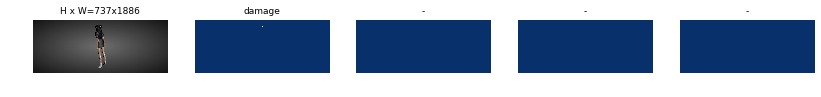

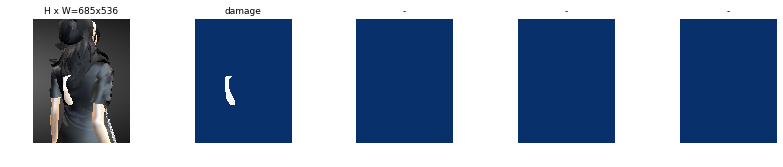

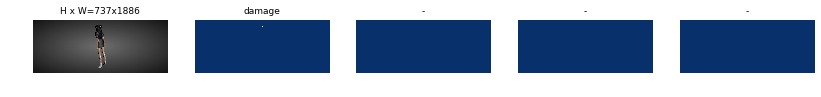

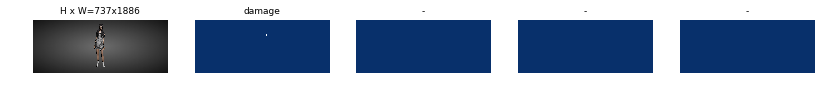

In [10]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)

for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)    
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [0]:
'''Initializing the models with pretrained weights'''

model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

In [12]:
'''Training Final layers of model'''
# Both Training and validation sets are same due to low amount of training data
model.train(dataset_train, dataset_train,
            learning_rate=config.LEARNING_RATE,
            epochs=1,
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/datasets/ubisoft/rcnn_retrain/logs/damage20190623T1624/mask_rcnn_damage_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4   

W0623 16:24:43.918705 139895017633664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Co

Epoch 1/1
1000/1000 [==============================] - 1174s 1s/step - loss: 0.4940 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1141 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.1534 - mrcnn_mask_loss: 0.2074 - val_loss: 0.1184 - val_rpn_class_loss: 0.0014 - val_rpn_bbox_loss: 0.0259 - val_mrcnn_class_loss: 0.0024 - val_mrcnn_bbox_loss: 0.0217 - val_mrcnn_mask_loss: 0.0670


### Predictions using Trained model

In [16]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NAME = "damage"
    NUM_CLASSES = 1 + 1  # background + damage

config_inf = InferenceConfig()
config_inf.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [20]:
print(MODEL_DIR)
model_inf = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config_inf)
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model_inf.find_last()
model_path = '/content/drive/My Drive/datasets/ubisoft/rcnn_retrain/logs/damage20190623T1624/mask_rcnn_damage_0001.h5'
print(model_path)

# Load trained weights
print("Loading weights from ", model_path)
model_inf.load_weights(model_path, by_name=True)

/content/drive/My Drive/datasets/ubisoft/rcnn_retrain/logs
/content/drive/My Drive/datasets/ubisoft/rcnn_retrain/logs/damage20190623T1624/mask_rcnn_damage_0001.h5
Loading weights from  /content/drive/My Drive/datasets/ubisoft/rcnn_retrain/logs/damage20190623T1624/mask_rcnn_damage_0001.h5
Re-starting from epoch 1


Processing 1 images
image                    shape: (803, 1070, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1070.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


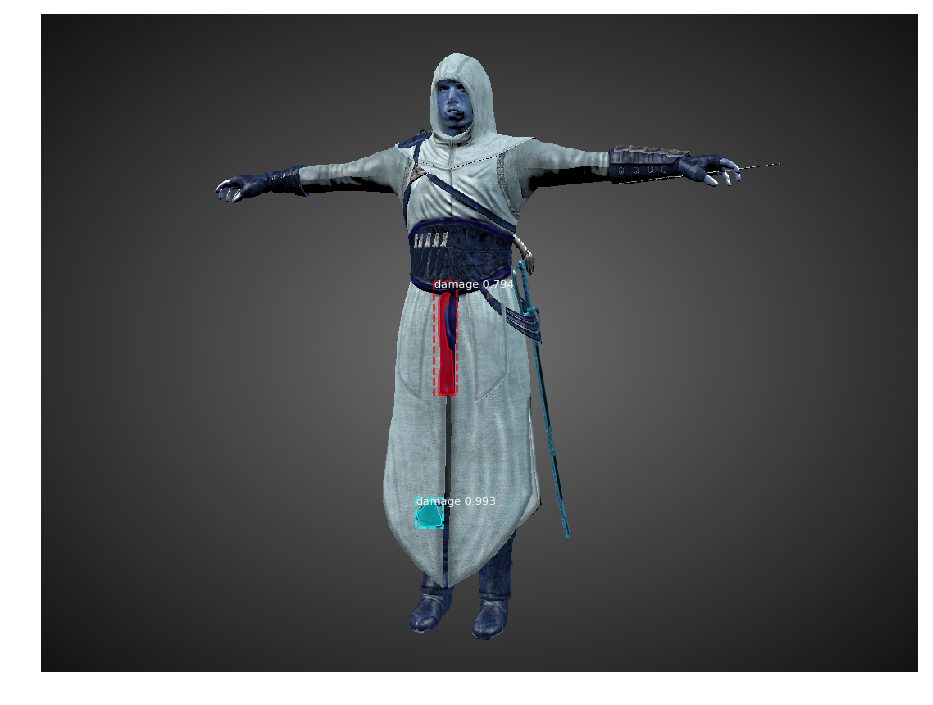

Processing 1 images
image                    shape: (803, 1070, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1070.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


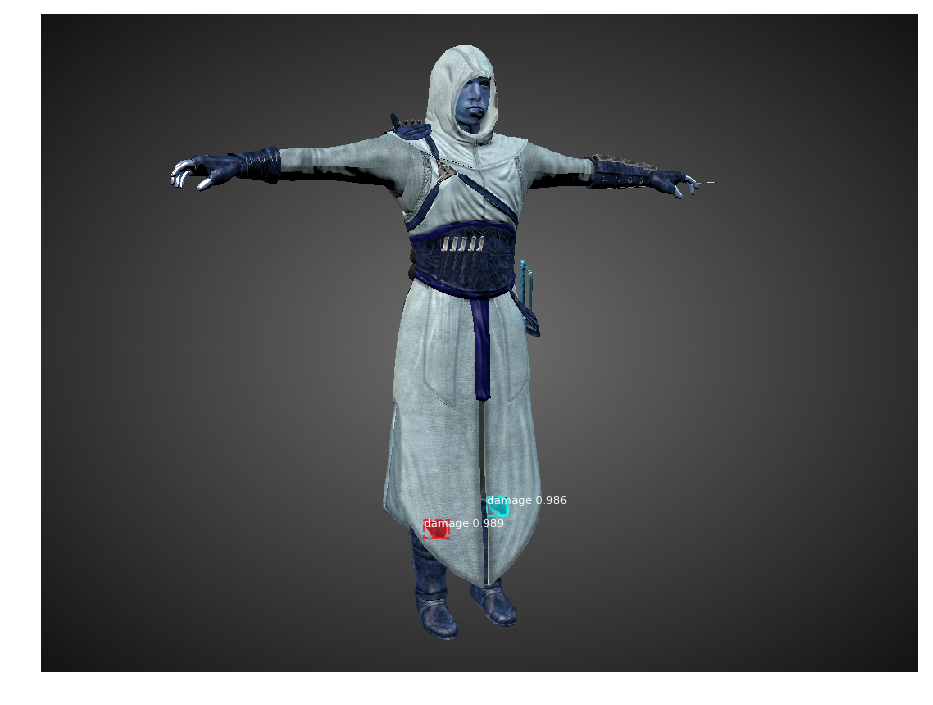

Processing 1 images
image                    shape: (803, 1070, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1070.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


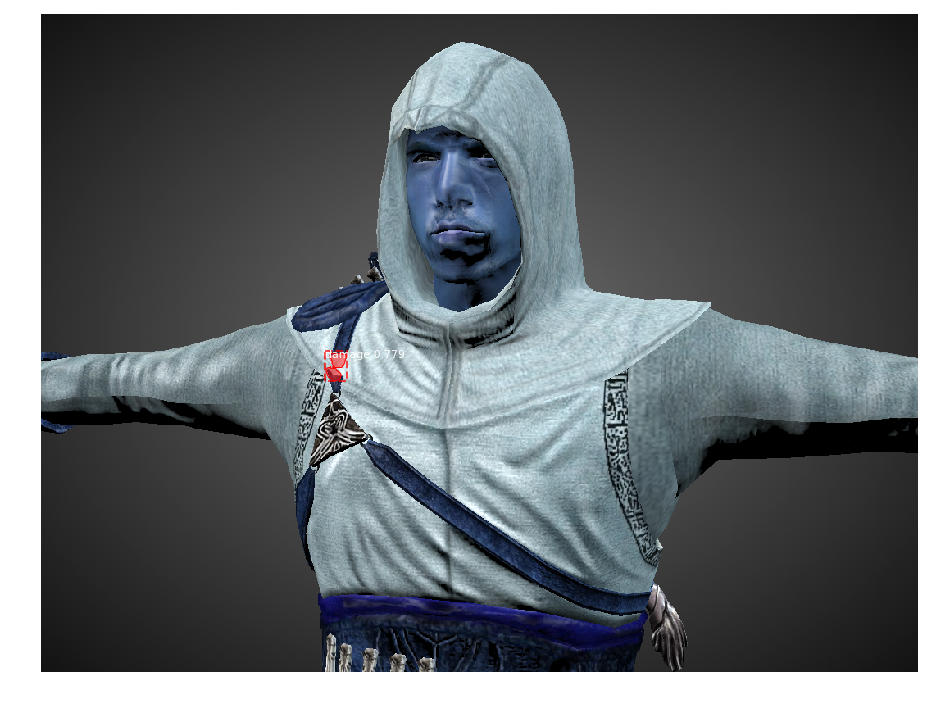

Processing 1 images
image                    shape: (737, 1886, 3)        min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1886.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


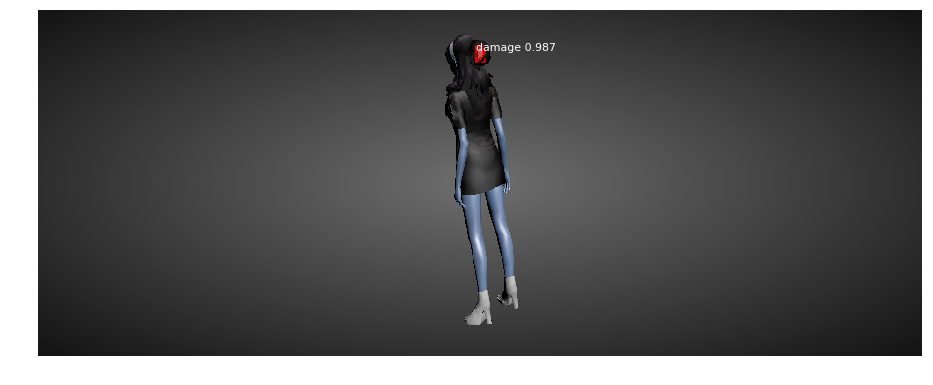

Processing 1 images
image                    shape: (803, 1070, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1070.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


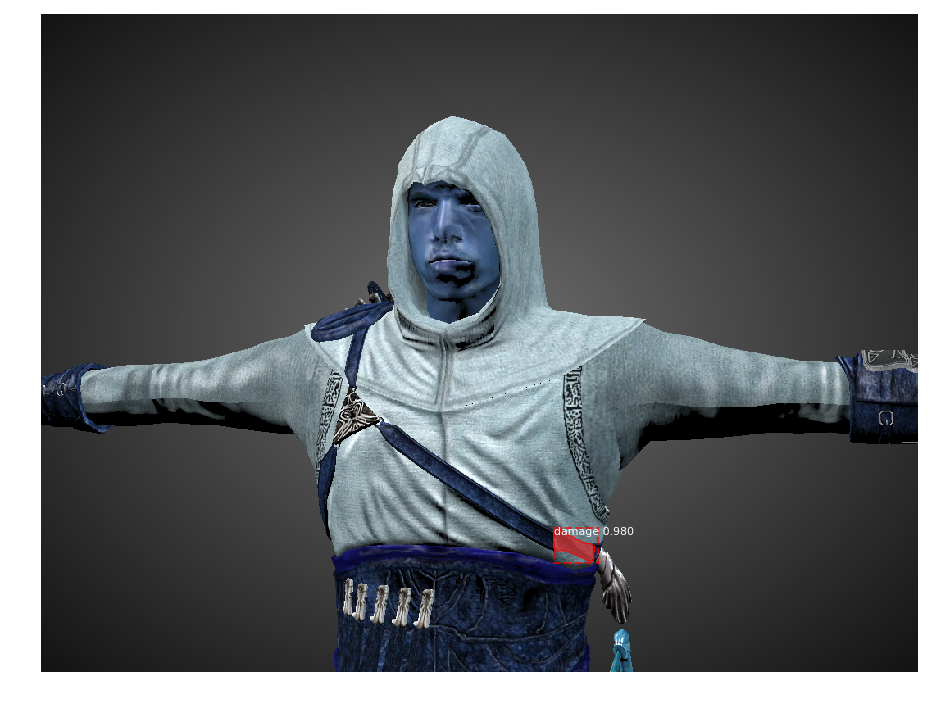

Processing 1 images
image                    shape: (803, 1070, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1070.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


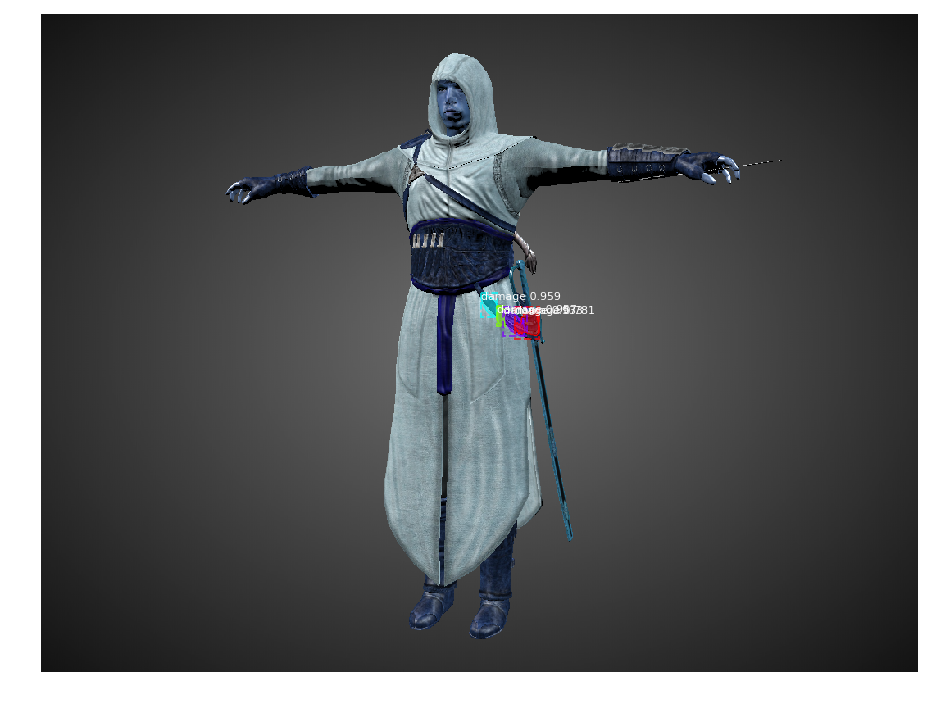

Processing 1 images
image                    shape: (737, 1886, 3)        min:    0.00000  max:  246.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  136.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1886.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


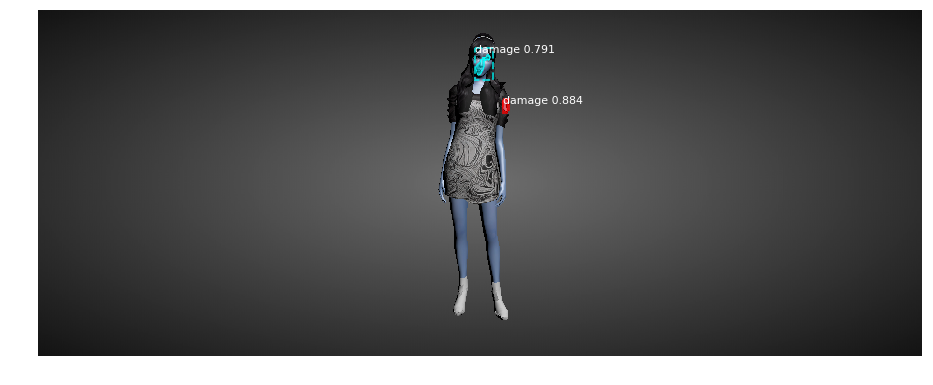

Processing 1 images
image                    shape: (336, 338, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


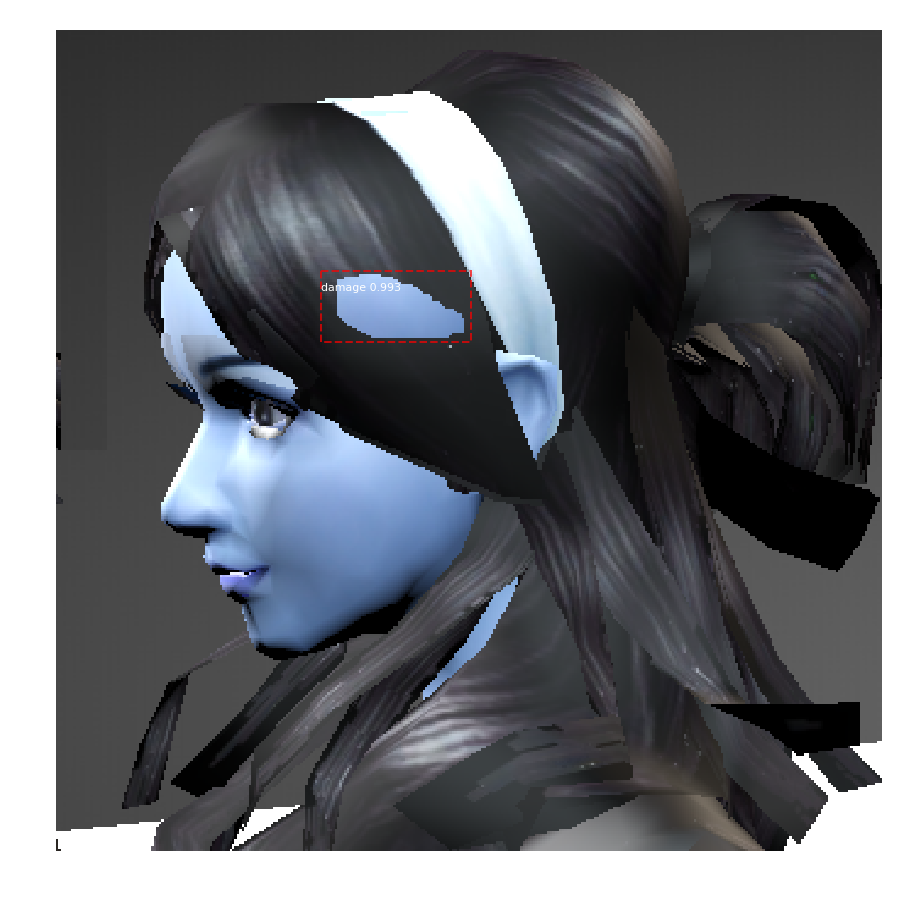

Processing 1 images
image                    shape: (684, 523, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


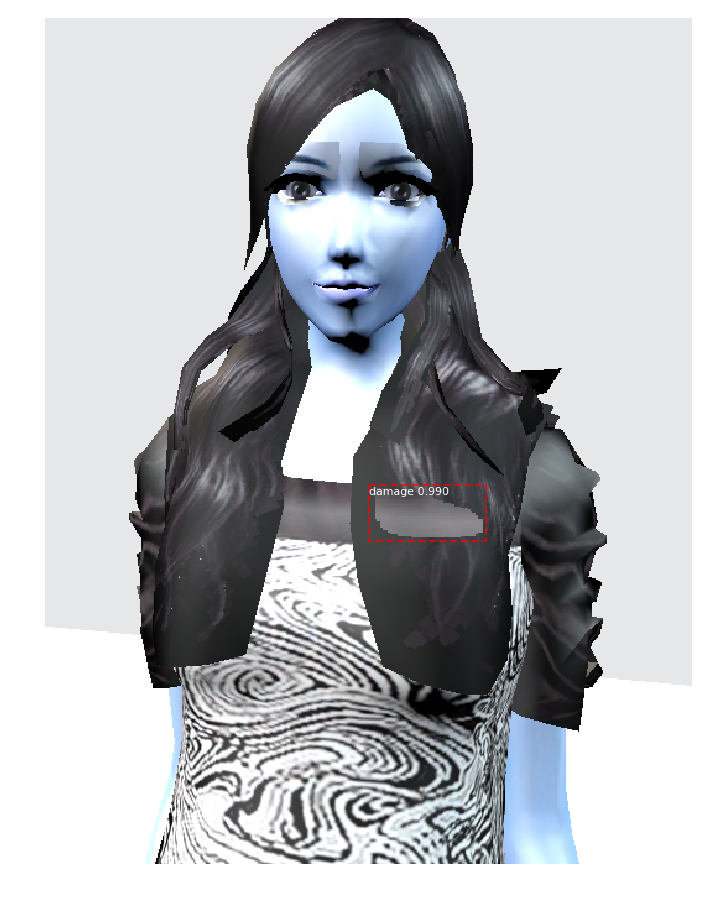

Processing 1 images
image                    shape: (686, 437, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


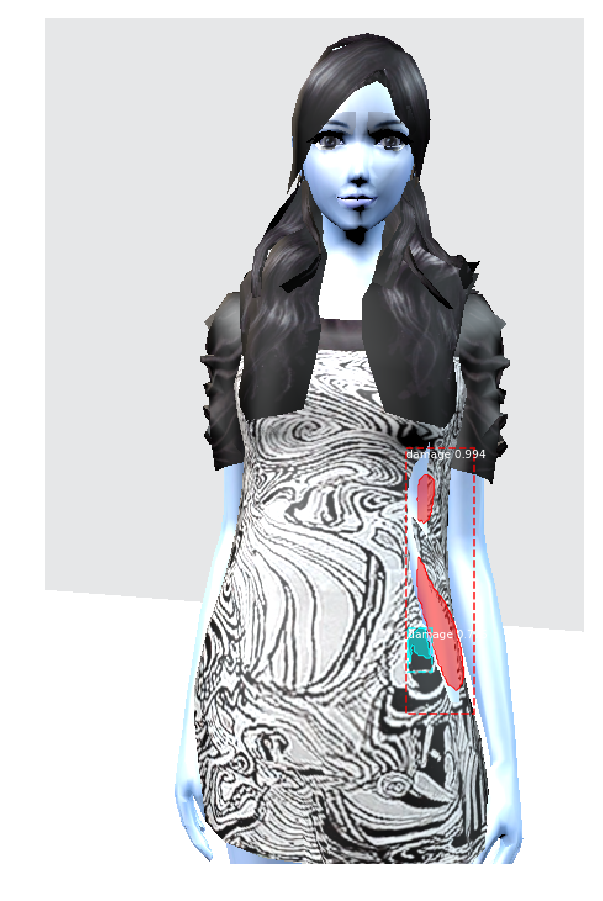

Processing 1 images
image                    shape: (685, 536, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


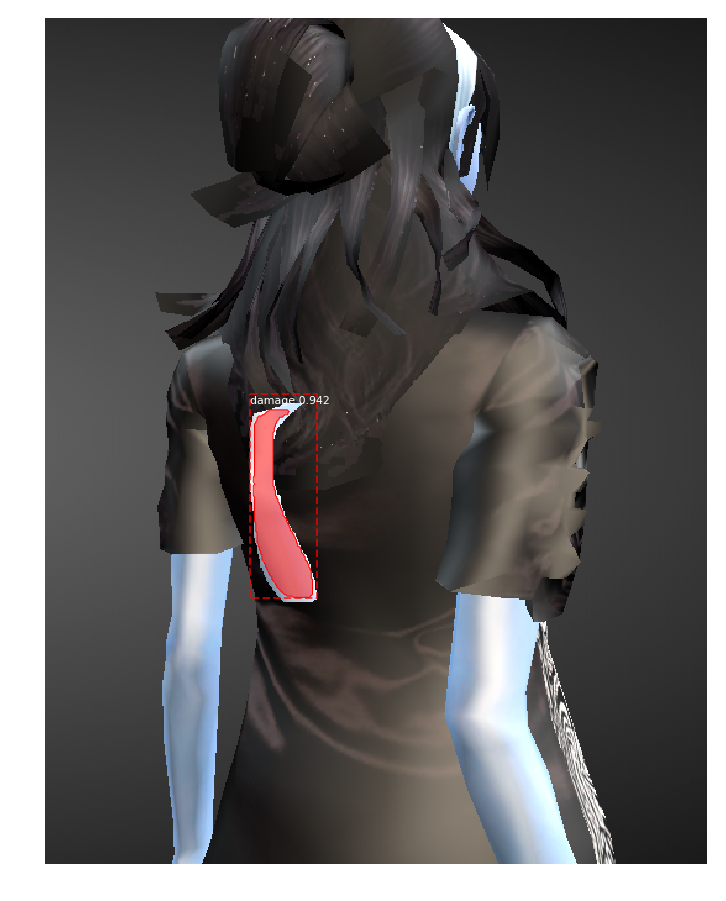

In [37]:
# Run detection
class_names = ['BG', 'damage']
for i in range(11):
  img_t = cv2.imread(train_files[i])
  results = model_inf.detect([img_t], verbose=1)
  # Visualize results
  r = results[0]
  visualize.display_instances(img_t, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
  plt.show()